In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.3 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torcheval.metrics.functional import peak_signal_noise_ratio

from sklearn.model_selection import train_test_split

#### Load dataset

In [3]:
ds_high_res_train_path = '/kaggle/input/image-super-resolution/dataset/train/high_res/'
ds_low_res_train_path = '/kaggle/input/image-super-resolution/dataset/train/low_res'
ds_high_res_val_path = '/kaggle/input/image-super-resolution/dataset/val/high_res'
ds_low_res_val_path = '/kaggle/input/image-super-resolution/dataset/val/low_res'

In [4]:
def get_path_img_ds(ds_path):
    dataset = []
    for img_name in os.listdir(ds_path):
        img_path = os.path.join(ds_path, img_name)
        dataset.append(img_path)
    return dataset

In [5]:
# train dataset
high_res_train_ds = get_path_img_ds(ds_high_res_train_path)
low_res_train_ds = get_path_img_ds(ds_low_res_train_path)

# val dataset
high_res_val_ds = get_path_img_ds(ds_high_res_val_path)
low_res_val_ds = get_path_img_ds(ds_low_res_val_path)

In [6]:
print(len(high_res_train_ds))
print(len(high_res_val_ds))

685
170


In [7]:
img_demo_high_res = np.array(Image.open(high_res_train_ds[0]).convert('RGB'))
img_demo_high_res.shape

(256, 256, 3)

In [8]:
img_demo_high_res = np.array(Image.open(high_res_train_ds[0]).convert('RGB'))
img_demo_low_res = np.array(Image.open(low_res_train_ds[0]).convert('RGB'))
print(img_demo_high_res.shape)
print(img_demo_low_res.shape)

(256, 256, 3)
(256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

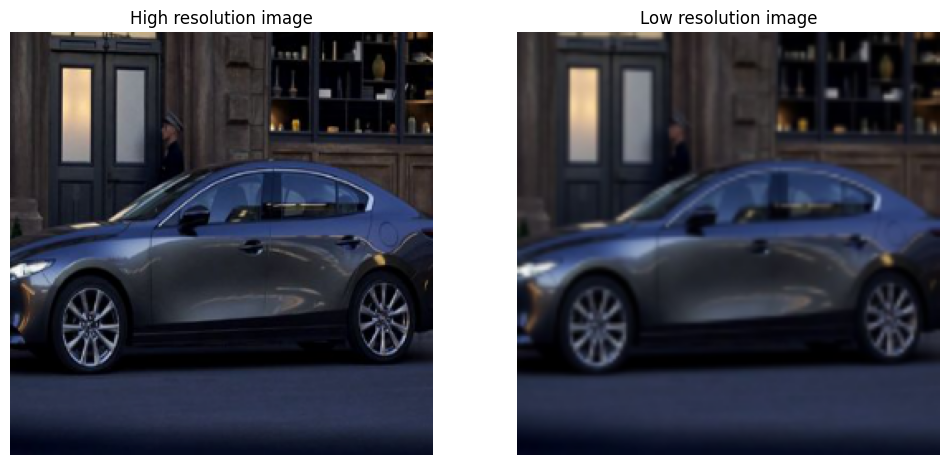

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(img_demo_high_res)
ax[0].set_title('High resolution image')
ax[0].axis('off')

ax[1].imshow(img_demo_low_res)
ax[1].set_title('Low resolution image')
ax[1].axis('off')

#### Datasets, DataLoader

In [10]:
class ImageDataset(Dataset):
    def __init__(self, high_img_ds, low_img_ds, is_train=False):
        self.high_img_ds = high_img_ds
        self.low_img_ds = low_img_ds
        self.is_train = is_train

    def __len__(self):
        return len(self.high_img_ds)

    def normalize(self, input_image, target_image):
        input_image = input_image*2 - 1
        target_image = target_image*2 - 1
        return input_image, target_image

    def random_jitter(self ,input_image, target_image):
        if torch.rand([]) < 0.5: 
            input_image = transforms.functional.hflip(input_image)
            target_image = transforms.functional.hflip(target_image)
        return input_image, target_image

    def __getitem__(self, index):
        low_img_path = self.low_img_ds[index]
        high_img_path = self.high_img_ds[index]
        
        low_img = np.array(Image.open(low_img_path).convert('RGB'))
        high_img = np.array(Image.open(high_img_path).convert('RGB'))
        
        low_img = transforms.functional.to_tensor(low_img)
        high_img = transforms.functional.to_tensor(high_img)

        input_image = low_img.type(torch.float32)
        target_image = high_img.type(torch.float32)

        # normalize input_image, target_image
        input_image, target_image = self.normalize(input_image, target_image)

        if self.is_train:
            input_image, target_image = self.random_jitter(input_image, target_image)

        return input_image, target_image

In [11]:
train_dataset = ImageDataset(
    high_res_train_ds,
    low_res_train_ds,
    is_train=True
)
val_dataset = ImageDataset(
    high_res_val_ds,
    low_res_val_ds,
    is_train=False
)

train_batch_size = 16
test_batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

#### Hàm train, evaluate

In [12]:
def evaluate(model, criterion, val_loader, device):
    model.eval()
    total_psnr, total_count = 0, 0
    losses = []
    with torch.no_grad():
        for img_inputs, img_targets in val_loader:
            img_inputs, img_targets = img_inputs.to(device), img_targets.to(device)
            
            predicts = model(img_inputs)
            
            loss = criterion(predicts, img_targets)
            losses.append(loss.item())

            total_psnr += peak_signal_noise_ratio(predicts, img_targets)
            total_count += 1
    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [13]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs, device, file_save_model, log_interval=50):
    train_losses = []
    val_losses = []
    
    train_psnrs = []
    val_psnrs = []

    for epoch in range(epochs):
        batch_train_loss = []

        model.train()
        total_psnr, total_count = 0, 0
        for idx, (img_inputs, img_targets) in enumerate(train_loader):
            img_inputs, img_targets = img_inputs.to(device), img_targets.to(device)

            optimizer.zero_grad()
            img_predicts = model(img_inputs)
            
            # loss
            loss = criterion(img_predicts, img_targets)
            loss.backward()

            # backward
            optimizer.step()
            batch_train_loss.append(loss.item())

            total_psnr += peak_signal_noise_ratio(img_predicts, img_targets)
            total_count += 1

        epoch_train_psnr = total_psnr / total_count
        train_loss = sum(batch_train_loss) / len(batch_train_loss)
        train_losses.append(train_loss)
        train_psnrs.append(epoch_train_psnr)
        
        epoch_val_psnr, epoch_val_loss = evaluate(model, criterion, val_loader, device)
        val_losses.append(epoch_val_loss)
        val_psnrs.append(epoch_val_psnr)
        print(f'Epoch {epoch + 1}:\tTrain Loss: {train_loss:.4f}\tTrain PSNR:{epoch_train_psnr:.4f}\tVal Loss: {epoch_val_loss:.4f}\tVal PSRN:{epoch_val_psnr:.4f}')

    # save model
    torch.save(model.state_dict(), file_save_model)
    
    return train_losses, train_psnrs, val_losses, val_psnrs

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Model UNet with Skip Connection

In [15]:
class FirstFeature(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class FeatureOut(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            # vì input range đang ở khoảng [-1, 1], nếu input range ở khoảng [0, 1] thì dùng hàm sigmoid
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_sample = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        up_sample = self.up_sample(x)
        concat = torch.concat([up_sample, skip], dim=1)
        return self.conv_block(concat)


class UNetArchitecture(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.first_feature = FirstFeature(in_channels, 64)
        self.conv = ConvBlock(64, 64)

        self.encoder1 = Encoder(64, 128)
        self.encoder2 = Encoder(128, 256)
        self.encoder3 = Encoder(256, 512)
        self.encoder4 = Encoder(512, 1024)

        self.decoder1 = Decoder(1024, 512)
        self.decoder2 = Decoder(512, 256)
        self.decoder3 = Decoder(256, 128)
        self.decoder4 = Decoder(128, 64)

        self.out_conv = FeatureOut(64, n_classes)

    def forward(self, x):
        x = self.first_feature(x)
        x1 = self.conv(x)

        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x4 = self.encoder3(x3)
        x5 = self.encoder4(x4)

        x = self.decoder1(x5, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)
        x = self.out_conv(x)

        return x

In [16]:
unet_model = UNetArchitecture(
    in_channels=3,
    n_classes=3,
)

# run parallel cuda if number of cuda > 1
# if torch.cuda.device_count() > 1:
#     unet_model = nn.DataParallel(unet_model)
unet_model.to(device)

UNetArchitecture(
  (first_feature): FirstFeature(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (conv): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (encoder1): Encoder(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddin

In [17]:
epochs = 100
lr = 1e-3
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=lr)

In [18]:
train_losses_skip, train_psnrs_skip, val_losses_skip, val_psnrs_skip = train(
    model=unet_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    epochs=epochs,
    device=device,
    file_save_model='unet_model_skip_connection_last.pt'
)

Epoch 1:	Train Loss: 0.1485	Train PSNR:20.3273	Val Loss: 0.1168	Val PSRN:21.3092
Epoch 2:	Train Loss: 0.1046	Train PSNR:22.9224	Val Loss: 0.0918	Val PSRN:23.7678
Epoch 3:	Train Loss: 0.0994	Train PSNR:23.4236	Val Loss: 0.0949	Val PSRN:23.4544
Epoch 4:	Train Loss: 0.0902	Train PSNR:24.1617	Val Loss: 0.0997	Val PSRN:23.5426
Epoch 5:	Train Loss: 0.0874	Train PSNR:24.4695	Val Loss: 0.0787	Val PSRN:25.0116
Epoch 6:	Train Loss: 0.0824	Train PSNR:24.9504	Val Loss: 0.0955	Val PSRN:21.8941
Epoch 7:	Train Loss: 0.0944	Train PSNR:23.9006	Val Loss: 0.0826	Val PSRN:25.0559
Epoch 8:	Train Loss: 0.0853	Train PSNR:24.8221	Val Loss: 0.0738	Val PSRN:25.7858
Epoch 9:	Train Loss: 0.0766	Train PSNR:25.4982	Val Loss: 0.0631	Val PSRN:26.7279
Epoch 10:	Train Loss: 0.0790	Train PSNR:25.3694	Val Loss: 0.0692	Val PSRN:26.0586
Epoch 11:	Train Loss: 0.0750	Train PSNR:25.7065	Val Loss: 0.0574	Val PSRN:27.4824
Epoch 12:	Train Loss: 0.0703	Train PSNR:26.2045	Val Loss: 0.0755	Val PSRN:25.4377
Epoch 13:	Train Loss: 0.0

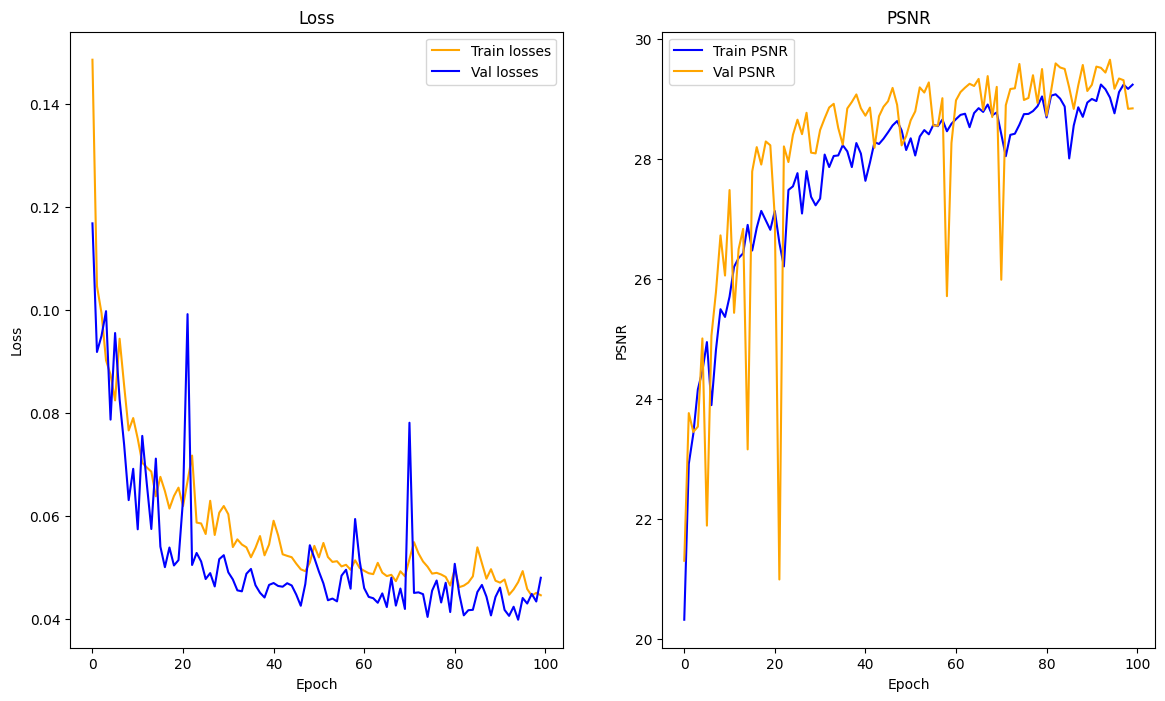

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 8))

train_psnrs_skip = [x.cpu().numpy() for x in train_psnrs_skip]
val_psnrs_skip = [x.cpu().numpy() for x in val_psnrs_skip]

ax[0].plot(train_losses_skip, color='orange', label='Train losses')
ax[0].plot(val_losses_skip, color='blue', label='Val losses')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(train_psnrs_skip, color='blue', label='Train PSNR')
ax[1].plot(val_psnrs_skip, color='orange', label='Val PSNR')
ax[1].set(xlabel='Epoch', ylabel='PSNR')
ax[1].set_title('PSNR')
ax[1].legend()

#### Model UNet with no Skip Connection

In [28]:
class FirstFeatureNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class FeatureOutNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlockNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class EncoderNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            ConvBlockNoSkip(in_channels, out_channels)
        )

    def forward(self, x):
        return self.encoder(x)


class DecoderNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_sample = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU()
        )
        self.conv_block = ConvBlockNoSkip(out_channels*2, out_channels)

    def forward(self, x):
        up_sample = self.up_sample(x)
        return self.conv_block(up_sample)


class UNetArchitectureNoSkip(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.first_feature = FirstFeatureNoSkip(in_channels, 64)
        self.conv = ConvBlockNoSkip(64, 64)

        self.encoder1 = EncoderNoSkip(64, 128)
        self.encoder2 = EncoderNoSkip(128, 256)
        self.encoder3 = EncoderNoSkip(256, 512)
        self.encoder4 = EncoderNoSkip(512, 1024)

        self.decoder1 = DecoderNoSkip(1024, 512)
        self.decoder2 = DecoderNoSkip(512, 256)
        self.decoder3 = DecoderNoSkip(256, 128)
        self.decoder4 = DecoderNoSkip(128, 64)

        self.out_conv = FeatureOutNoSkip(64, n_classes)

    def forward(self, x):
        x = self.first_feature(x)
        x = self.conv(x)

        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.encoder4(x)

        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)
        x = self.out_conv(x)

        return x

In [29]:
unet_model_no_skip = UNetArchitectureNoSkip(
    in_channels=3,
    n_classes=3,
)

# run parallel cuda if number of cuda > 1
# if torch.cuda.device_count() > 1:
#     unet_model_no_skip = nn.DataParallel(unet_model_no_skip)
unet_model_no_skip.to(device)

UNetArchitectureNoSkip(
  (first_feature): FirstFeatureNoSkip(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (conv): ConvBlockNoSkip(
    (conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (encoder1): EncoderNoSkip(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlockNoSkip(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size

In [30]:
epochs = 100
lr = 1e-3
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(unet_model_no_skip.parameters(), lr=lr)

In [31]:
train_losses_skip, train_psnrs_skip, val_losses_skip, val_psnrs_skip = train(
    model=unet_model_no_skip,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    epochs=epochs,
    device=device,
    file_save_model='unet_model_no_skip_last.pt'
)

Epoch 1:	Train Loss: 0.3082	Train PSNR:13.8990	Val Loss: 0.3341	Val PSRN:12.6324
Epoch 2:	Train Loss: 0.2441	Train PSNR:15.2969	Val Loss: 0.2900	Val PSRN:13.9281
Epoch 3:	Train Loss: 0.2432	Train PSNR:15.3459	Val Loss: 0.2417	Val PSRN:15.0184
Epoch 4:	Train Loss: 0.2248	Train PSNR:15.8085	Val Loss: 0.2449	Val PSRN:15.3675
Epoch 5:	Train Loss: 0.2197	Train PSNR:15.9995	Val Loss: 0.2310	Val PSRN:15.5769
Epoch 6:	Train Loss: 0.2175	Train PSNR:16.0236	Val Loss: 0.2124	Val PSRN:16.1070
Epoch 7:	Train Loss: 0.2203	Train PSNR:15.9409	Val Loss: 0.2159	Val PSRN:16.1209
Epoch 8:	Train Loss: 0.2132	Train PSNR:16.1315	Val Loss: 0.2163	Val PSRN:16.1087
Epoch 9:	Train Loss: 0.2120	Train PSNR:16.1698	Val Loss: 0.2365	Val PSRN:15.5117
Epoch 10:	Train Loss: 0.2099	Train PSNR:16.2402	Val Loss: 0.2417	Val PSRN:15.1101
Epoch 11:	Train Loss: 0.2066	Train PSNR:16.3773	Val Loss: 0.2235	Val PSRN:15.8465
Epoch 12:	Train Loss: 0.2066	Train PSNR:16.3619	Val Loss: 0.2220	Val PSRN:16.0264
Epoch 13:	Train Loss: 0.2

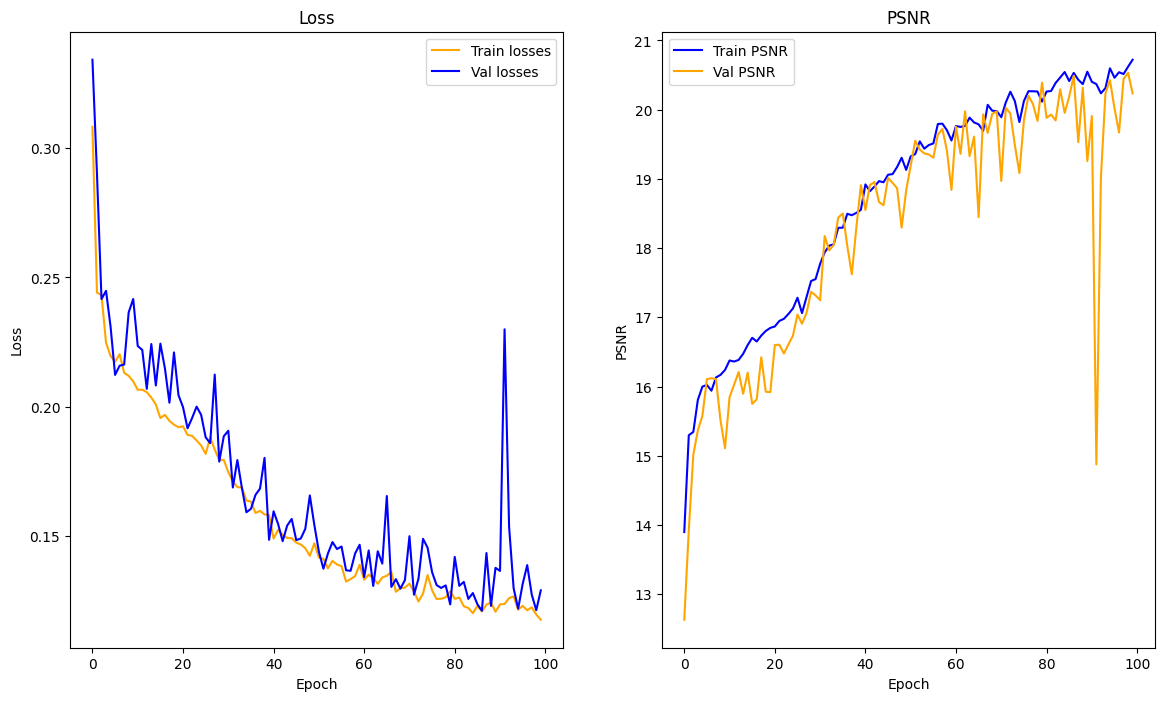

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 8))

train_psnrs_skip = [x.cpu().numpy() for x in train_psnrs_skip]
val_psnrs_skip = [x.cpu().numpy() for x in val_psnrs_skip]

ax[0].plot(train_losses_skip, color='orange', label='Train losses')
ax[0].plot(val_losses_skip, color='blue', label='Val losses')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(train_psnrs_skip, color='blue', label='Train PSNR')
ax[1].plot(val_psnrs_skip, color='orange', label='Val PSNR')
ax[1].set(xlabel='Epoch', ylabel='PSNR')
ax[1].set_title('PSNR')
ax[1].legend()